In [21]:
import torch
import torch.nn as nn
import torch.functional as F
import torchvision.transforms as transforms
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
from utils import new_labels, new_labels_to_category

c:\Users\ryanp\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **GTSRB**

German Traffic Sign Recognition Benchmark: In this notebook, I'll train an image classification model using PyTorch. 

For this task I chose the GTSRB dataset provided by the torchvision lybrary.

https://pytorch.org/vision/stable/generated/torchvision.datasets.GTSRB.html#torchvision.datasets.GTSRB

## **Step 1: Exploratory Data Analysis**

TODO:
* Look up the classes
* Plot the distribution
* Fix eventual problems with the data

### **Downloading data** 

In [22]:
transforms = transforms.Compose([
        transforms.Resize([60,60]), # the image are not all equal in size, we need to define a standard size
        transforms.ToTensor() # converts images to torch Tensors and rescales pixels to [0;1] 
    ])

train_dataset = torchvision.datasets.GTSRB(
    root='.',
    split='train',
    transform=transforms,
    download=True
)

### **Data Loader**

In [23]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

### **Visualization**

Image shape: torch.Size([128, 3, 60, 60]), label shape: torch.Size([128])
Min and max pixel values: [0.0, 1.0]
Number of classes 42


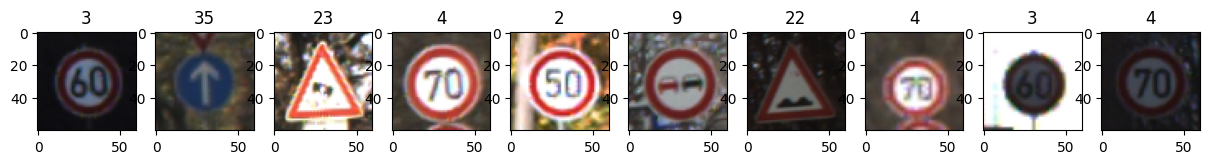

In [89]:
for x, y in train_loader:
    print(f'Image shape: {x.shape}, label shape: {y.shape}')
    print(f'Min and max pixel values: [{torch.min(x)}, {torch.max(x)}]')
    print(f'Number of classes {torch.max(y)}')
    figure, axis = plt.subplots(1, 10, figsize=(15,15))
    for idx in range(10):
        axis[idx].imshow(x[idx].permute(1, 2, 0))
        axis[idx].set_title(y[idx].numpy())
    break

We can see from this first plot that the images are labeled with numbers from 0 to 42, meaning there 43 classes. As a first step, we could try to reduce the number of classes by grouping similar traffic signs together (speed limit, change of direction, ...)

Another thing to see is that images vary largely in contrast, sharpness and quality, it might not be useful to try to augment the data as the difference between images is already really high.

<img src='https://miro.medium.com/max/1100/1*mWK70K4agwvlwR-JBiT-aw.webp' style="background-color:white" width="600" height="500" />

### **Creating new classes** 

In [72]:
assert len(new_labels.keys()) == 43, "Some labels might not have been replaced"

In [61]:
def convert_labels(label_batch):
    """
    input: label_batch (torch.Tensor), a sequence of original labels
    output: (torch.Tensor) a sequence of labels corresponding to the new classes
    """
    global new_labels
    assert torch.is_tensor(label_batch), "the input batch sequence is not a torch tensor"
    
    return torch.tensor([new_labels.get(i) for i in y.numpy()])

for x,y in train_loader:
    print(convert_labels(y))
    break

tensor([3, 6, 3, 1, 1, 5, 1, 1, 1, 2, 2, 1, 3, 2, 2, 3, 1, 2, 6, 1, 6, 2, 2, 5,
        3, 6, 3, 1, 1, 3, 1, 1, 4, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 7, 6, 3, 6,
        3, 3, 3, 5, 3, 5, 1, 1, 2, 3, 6, 1, 1, 2, 5, 7, 2, 3, 3, 3, 5, 5, 1, 1,
        4, 6, 2, 3, 2, 1, 2, 2, 1, 1, 2, 2, 6, 1, 3, 5, 1, 1, 2, 1, 3, 2, 1, 1,
        5, 2, 5, 3, 3, 5, 1, 3, 4, 3, 2, 1, 1, 1, 2, 6, 1, 1, 1, 1, 5, 1, 3, 1,
        1, 1, 5, 1, 1, 5, 1, 3])


### **Data balancing**

In [63]:
full_train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_dataset.__len__(),
)

In [65]:
for x, y in full_train_loader:
    original_labels = convert_labels(y)

In [87]:
fig = px.histogram(original_labels.numpy(), text_auto=True, title="Training samples distribution for the new classes")
fig.show()

if not os.path.exists("images"):
    os.mkdir("images")
# fig.write_image("images/training_distribution.jpeg")

This graph reveals a slight inbalance in the label distribution we created. The underrepresented classes are "End of limitation" and "Stop" as they refer to few different traffic signs. If the performances on these classes are underwhelming, we can apply class weights in order to bring some balance or use data augmentation to create new samples artificially.

# **Step 2: Modeling**

TODO:
* Define a model architecture
* Define a loss and an optimizer

Output size of a convolutional layer :


*   W = input shape
*   F = kernel size
*   P = padding
*   S = Stride

$W_{out} = \left \lfloor \frac{W - F + 2P}{S} \right \rfloor +1$

In [98]:
def conv_arithmetic(input_size, kernel_size, padding, stride):
  """ 
  Returns the output shape of an image after one iteration of "Zero padding, non-unit strides" convolution
  reference: https://theano-pymc.readthedocs.io/en/latest/tutorial/conv_arithmetic.html
  """
  return np.floor((input_size + 2*padding - kernel_size)/stride) + 1

size = 60
for _ in range(4):
  size = conv_arithmetic(size, kernel_size=3, padding=1, stride=2)
  print(size)

30.0
15.0
8.0
4.0
